In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
import umap.plot

/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/

In [3]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
niter = 3

models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)

specs, recon, true_cont = [], [], []
redshifts, weights, norms, latents = [], [], [], [] 
for ibatch in range(50): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    specs.append(np.array(spec))
    norms.append(np.array(norm))
    redshifts.append(np.array(z))
    weights.append(np.array(w))
    
    # latents
    latents.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.latents.npy' % (niter, ibatch)))

    # load SpenderQ recon 
    recon.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.recons.npy' % (niter, ibatch)))

    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch)))
    
specs = np.concatenate(specs, axis=0)
norms = np.concatenate(norms)
redshifts = np.concatenate(redshifts)
weights = np.concatenate(weights, axis=0)
latents = np.concatenate(latents)

recon = np.concatenate(recon, axis=0)
true_cont = np.concatenate(true_cont, axis=0)

w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [5]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []
bad_recon = []
for igal in range(len(redshifts)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+redshifts[igal])) & ((wave_rest_rebin < 9.9e3/float(1+redshifts[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
        np.array(true_cont[igal]/norms[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    # rebin reconstruction
    recon_rebin = U.trapz_rebin(
        w_recon, 
        recon[igal], 
        xnew=wave_rest_rebin[wlim])
    
    # residual
    dcont = np.repeat(-999., len(wave_rest_rebin))
    dcont[wlim] = true_rebin - recon_rebin 
    
    # fractional residual
    dfcont = np.repeat(-999., len(wave_rest_rebin))
    dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin

    dcont_recon.append(dcont)
    dfcont_recon.append(dfcont)
    
    # check for bad recons
    wlim = (wave_rest_rebin > np.max([1040, 3.6e3/float(1+redshifts[igal])])) & (wave_rest_rebin < 1150)
    if np.median(dfcont[wlim]) > 0.25: 
        bad_recon.append(True)
    else: 
        bad_recon.append(False)
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
snr = weights**0.5 * specs
median_snr = np.median(snr, axis=1) * norms

In [7]:
umapper = umap.UMAP().fit(np.array(latents))

## UMAP --- redshift

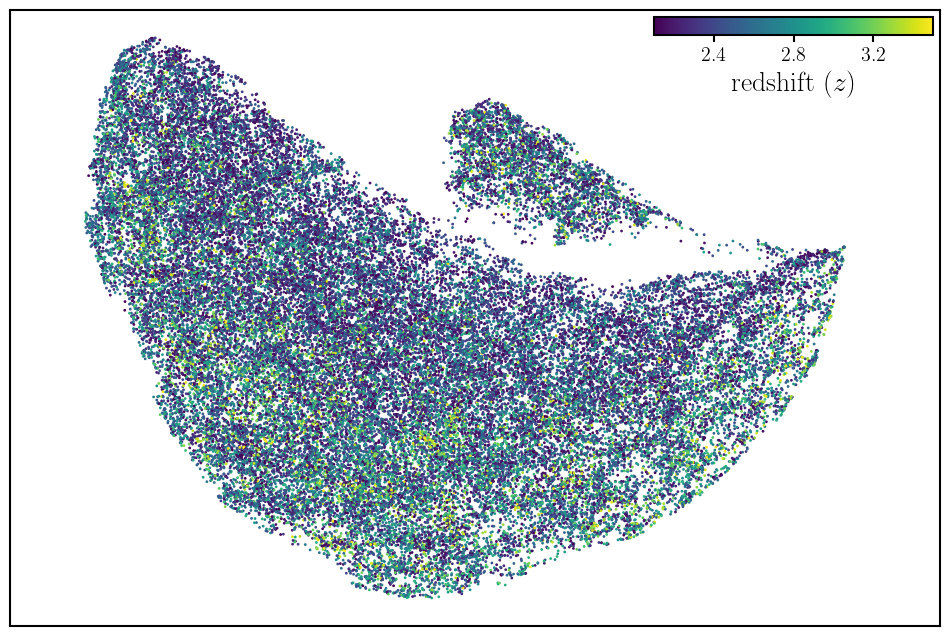

In [8]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

sub.set_xticks([])
sub.set_xlim(-6, 14)
sub.set_yticks([])

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='redshift ($z$)', size=20)
#fig.savefig('london_latents.pdf')#, bbox_inches='tight')

# UMAP --- SNR

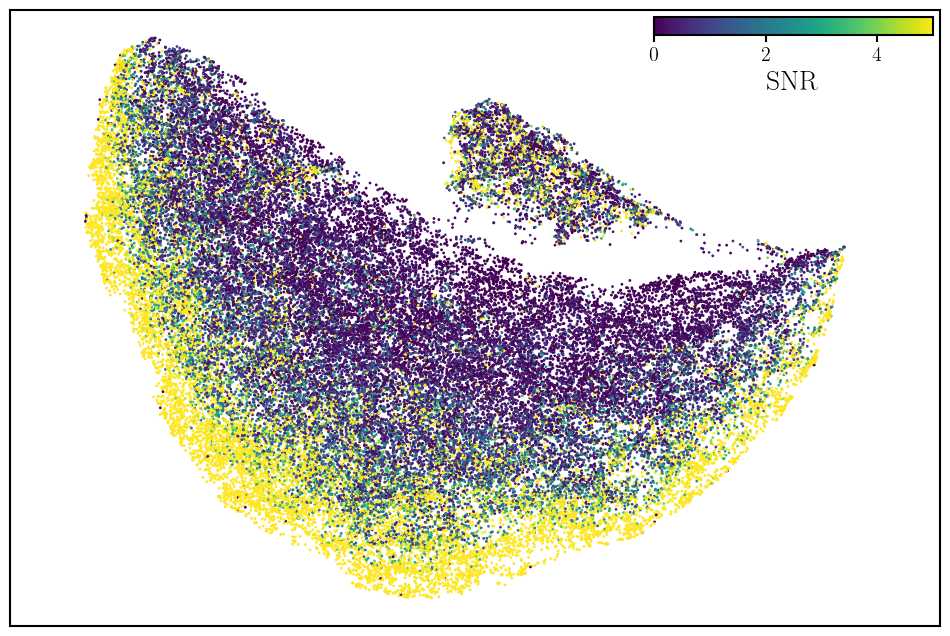

In [49]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=median_snr, cmap='viridis', vmin=0., vmax=5., rasterized=True)

sub.set_xticks([])
sub.set_xlim(-6, 14)
sub.set_yticks([])

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
#cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='SNR', size=20)
#fig.savefig('london_latents.pdf')#, bbox_inches='tight')

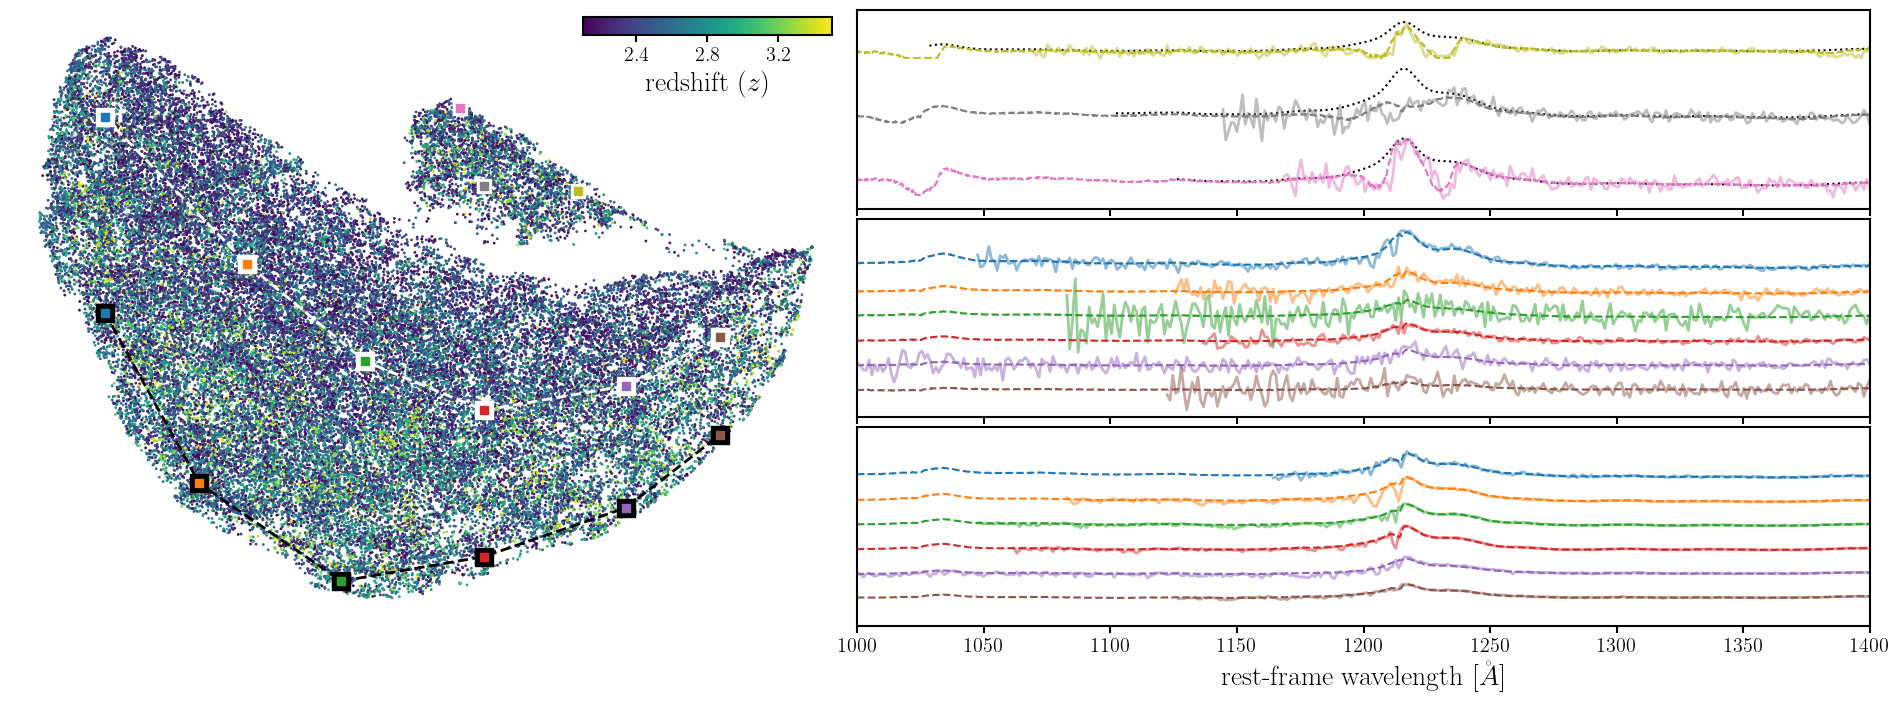

In [48]:
track1 = np.array([(-3., 6), (0.0, 3.0), (2.5, 1.0), (5.0, 0.0), (8, 0.5), (10.0, 1.5)])
track2 = np.array([(-3., 2.0), (-1, -1.5), (2., -3.5), (5.0, -3.), (8, -2), (10.0, -0.5)])
bad_track = np.array([(4.5, 6.2), (5., 4.6), (7.0, 4.5)])



fig = plt.figure(figsize=(24, 8))
gs0 = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=(0.45, 0.55))

sub = plt.subplot(gs0[0])
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

for ii, point in enumerate(bad_track): 
    sub.scatter([point[0]], [point[1]], marker='s', s=100, c='white', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=30, c='C%i' % (ii+6), zorder=11)

sub.plot(track1[:,0], track1[:,1], lw=2, ls='--', c='white')
for ii, point in enumerate(track1): 
    sub.scatter([point[0]], [point[1]], marker='s', s=150, c='white', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=30, c='C%i' % ii, zorder=11)
    
sub.plot(track2[:,0], track2[:,1], lw=2, ls='--', c='k')
for ii, point in enumerate(track2): 
    sub.scatter([point[0]], [point[1]], marker='s', s=150, c='k', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=30, c='C%i' % ii, zorder=11)
    
sub.set_xlim(-5., 12.5)
sub.set_xticks([])
sub.set_yticks([])
sub.axis('off')

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='redshift ($z$)', size=20)

sub_right = mpl.gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[1])

sub = plt.subplot(sub_right[0])
for ii, point in enumerate(bad_track): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)        
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+10*ii, c='k', ls=':')    
    sub.plot(wave_rest_rebin[wlim], _spec+10*ii, c='C%i' % (ii+6), lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+10*ii, c='C%i' % (ii+6), ls='--')

sub.set_xlim(1000., 1400.)
sub.set_xticklabels([])
sub.set_ylim(-2., 27)
sub.set_yticks([])

sub = plt.subplot(sub_right[1])
for ii, point in enumerate(track1): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)
    #sub.plot(models[0].wave_obs/(1.+redshifts[iclosest]), specs[iclosest,:], c='C%i' % ii, lw=2)
        
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(wave_rest_rebin[wlim], _spec+5*(6-ii), c='C%i' % ii, lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+5*(6-ii), c='C%i' % ii, ls='--')
sub.set_xlim(1000., 1400.)
sub.set_xticklabels([])
sub.set_ylim(0., 42)
sub.set_yticks([])    
    
sub = plt.subplot(sub_right[2])
for ii, point in enumerate(track2): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)
    #sub.plot(models[0].wave_obs/(1.+redshifts[iclosest]), specs[iclosest,:], c='C%i' % ii, lw=2)
        
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(wave_rest_rebin[wlim], _spec+5*(6-ii), c='C%i' % ii, lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+5*(6-ii), c='C%i' % ii, ls='--')    
    
sub.set_xlim(1000., 1400.)
sub.set_xlabel(r"rest-frame wavelength [$\AA$]", fontsize=20)
sub.set_ylim(0., 42)
sub.set_yticks([])
fig.subplots_adjust(hspace=0.05, wspace=0.02)
fig.savefig('latents_demo.pdf')